In [1]:
from keras.models import *
from keras.layers import *
import keras

Using TensorFlow backend.


In [2]:
import numpy as np                        # ndarrys for gridded data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import seaborn as sns                     # for plotting
import warnings                           # supress warnings from seaborn pairplot
import cv2 
import random
import tensorflow as tf
import keras.backend as K
from keras.utils import to_categorical
import glob
import keras
from PIL import Image
import json
import os
import gc
from tqdm import notebook, tnrange
import tifffile as tiff
from sklearn.model_selection import train_test_split
import time
import datetime
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [3]:
os.chdir("/home/ahadmomin/project")

In [4]:
def iou_loss(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def iou(y_true, y_pred, label: int):
    """
    Return the Intersection over Union (IoU) for a given label.
    Args:
        y_true: the expected y values as a one-hot
        y_pred: the predicted y values as a one-hot or softmax output
        label: the label to return the IoU for
    Returns:
        the IoU for the given label
    """
    # extract the label values using the argmax operator then
    # calculate equality of the predictions and truths to the label
    y_true = K.cast(K.equal(K.argmax(y_true), label), K.floatx())
    y_pred = K.cast(K.equal(K.argmax(y_pred), label), K.floatx())
    # calculate the |intersection| (AND) of the labels
    intersection = K.sum(y_true * y_pred)
    # calculate the |union| (OR) of the labels
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    # avoid divide by zero - if the union is zero, return 1
    # otherwise, return the intersection over union
    return K.switch(K.equal(union, 0), 1.0, intersection / union)


def build_iou_for(label: int, name: str=None):
    """
    Build an Intersection over Union (IoU) metric for a label.
    Args:
        label: the label to build the IoU metric for
        name: an optional name for debugging the built method
    Returns:
        a keras metric to evaluate IoU for the given label
        
    Note:
        label and name support list inputs for multiple labels
    """
    # handle recursive inputs (e.g. a list of labels and names)
    if isinstance(label, list):
        if isinstance(name, list):
            return [build_iou_for(l, n) for (l, n) in zip(label, name)]
        return [build_iou_for(l) for l in label]

    # build the method for returning the IoU of the given label
    def label_iou(y_true, y_pred):
        """
        Return the Intersection over Union (IoU) score for {0}.
        Args:
            y_true: the expected y values as a one-hot
            y_pred: the predicted y values as a one-hot or softmax output
        Returns:
            the scalar IoU value for the given label ({0})
        """.format(label)
        return iou(y_true, y_pred, label)

    # if no name is provided, us the label
    if name is None:
        name = label
    # change the name of the method for debugging
    label_iou.__name__ = 'iou_{}'.format(name)

    return label_iou
        

def mean_iou(y_true, y_pred):
    """
    Return the Intersection over Union (IoU) score.
    Args:
        y_true: the expected y values as a one-hot
        y_pred: the predicted y values as a one-hot or softmax output
    Returns:
        the scalar IoU value (mean over all labels)
    """
    # get number of labels to calculate IoU for
    num_labels = K.int_shape(y_pred)[-1]
    # initialize a variable to store total IoU in
    total_iou = K.variable(0)
    # iterate over labels to calculate IoU for
    for label in range(num_labels):
        total_iou = total_iou + iou(y_true, y_pred, label)
    # divide total IoU by number of labels to get mean IoU
    return total_iou / num_labels


smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [5]:

def create_numpyset(path_X ='/k',
                    path_y = '/k',
                    new_path_X= 'train_numpy/',
                    new_path_y='train_numpy/'):
    
    X=[]
    y=[]
    
    ids = next(os.walk(path_X))[1]
    print("Numnber of images = ", len(ids))    
    
    for n, id_ in notebook.tqdm(enumerate(ids), total=len(ids)):
        
        names_R=(path_X+id_+"/tomo/"+id_+".tif")
        names_y=(path_X+id_+"/seg/"+id_+".tif")
        print(names_R)
        print(names_y)
        X.append(cv2.resize(cv2.imread(names_R,1),(512,512)))
        y.append(cv2.resize(cv2.imread(names_y,-1),(512,512)))

    X= (X - np.min(X)) / (np.max(X) - np.min(X))
    print(X, X.shape)
    
    y= to_categorical(y).astype(np.uint8)
    
    X= X.astype(np.float16)
    print(X.shape)
    print(y.shape)    
        
    try:
        os.mkdir(new_path_X + '/X' )
        os.mkdir(new_path_y + '/y' )
    except: 
        print('folder exits')
    
    for im_num in range( np.shape(X)[0] ):
        np.save( new_path_X + '/X/' + f'{im_num}', X[im_num,:,:,:]  )
        np.save( new_path_y + '/y/' + f'{im_num}', y[im_num,:,:,:]  )

In [6]:
# create_numpyset(path_X ='stage2_test2D/',
#                     path_y = '/stage2_test2D',
#                     new_path_X= 'test_numpy/',
#                     new_path_y='test_numpy/')

In [7]:
num_gpus =3
total_samples=2400
batch_size=6
epochs =50
train_ids = np.arange(0, total_samples)
image_dims = (512,512)
filters_first_layer = 64
## Validation Data Size
val_data_size = 263
validation_split=0.2
file_loc1= 'train_numpy/'
file_loc2= 'test_numpy/'

In [8]:
all_dirs = glob.glob(file_loc1 + '/X/*.npy')

X_train = np.zeros((len(all_dirs),image_dims[0],image_dims[1],3)).astype(np.float32)
y_train = np.zeros((len(all_dirs),image_dims[0],image_dims[1],4)).astype(np.int8)

for im_num in notebook.tqdm(range( len(all_dirs) )):
    
    X_train[im_num,:,:,:] = np.load( file_loc1 + f'/X/{im_num}.npy' )
    y_train[im_num,:,:,:] = np.load( file_loc1 + f'/y/{im_num}.npy' )

In [9]:
all_dirs = glob.glob(file_loc2 + '/X/*.npy')

X_test = np.zeros((len(all_dirs),image_dims[0],image_dims[1],3)).astype(np.float32)
y_test = np.zeros((len(all_dirs),image_dims[0],image_dims[1],4)).astype(np.int8)

for im_num in notebook.tqdm(range( len(all_dirs) )):
    
    X_test[im_num,:,:,:] = np.load( file_loc2 + f'/X/{im_num}.npy' )
    y_test[im_num,:,:,:] = np.load( file_loc2 + f'/y/{im_num}.npy' )

Text(0.5, 1.0, 'Segmented(GR)-Phase4')

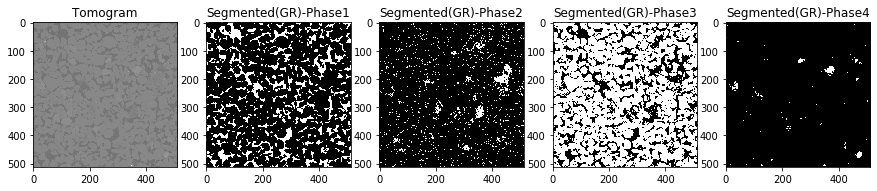

In [10]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (15, 15))
ax1.imshow(X_train[2])
ax1.set_title('Tomogram')
ax2.imshow((y_train[2,...,0]), cmap = 'gray')
ax2.set_title('Segmented(GR)-Phase1')
ax3.imshow((y_train[2,...,1]), cmap = 'gray')
ax3.set_title('Segmented(GR)-Phase2')
ax4.imshow((y_train[2,...,2]), cmap = 'gray')
ax4.set_title('Segmented(GR)-Phase3')
ax5.imshow((y_train[2,...,3]), cmap = 'gray')
ax5.set_title('Segmented(GR)-Phase4')

Text(0.5, 1.0, 'Segmented(GR)-Phase4')

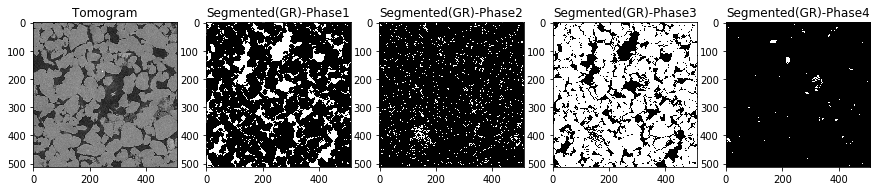

In [11]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (15, 15))
ax1.imshow(X_test[2,...,1], cmap= 'gray')
ax1.set_title('Tomogram')
ax2.imshow((y_test[1,...,0]), cmap = 'gray')
ax2.set_title('Segmented(GR)-Phase1')
ax3.imshow((y_test[1,...,1]), cmap = 'gray')
ax3.set_title('Segmented(GR)-Phase2')
ax4.imshow((y_test[1,...,2]), cmap = 'gray')
ax4.set_title('Segmented(GR)-Phase3')
ax5.imshow((y_test[1,...,3]), cmap = 'gray')
ax5.set_title('Segmented(GR)-Phase4')

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=2020)

In [13]:
print("Tomogram dimension in Training = ", X_train.shape,X_train.dtype)
print("Segmented dimension in Training  = ",y_train.shape, y_train.dtype)
print("Tomogram dimension in val = ",X_valid.shape, X_valid.dtype)
print("Segmented dimension in val = ",y_valid.shape, y_valid.dtype)
print("Tomogram dimension in Testing = ",X_test.shape, X_test.dtype)
print("Segmented dimension in Testing = ",y_test.shape, y_test.dtype)

Tomogram dimension in Training =  (1920, 512, 512, 3) float32
Segmented dimension in Training  =  (1920, 512, 512, 4) int8
Tomogram dimension in val =  (480, 512, 512, 3) float32
Segmented dimension in val =  (480, 512, 512, 4) int8
Tomogram dimension in Testing =  (2400, 512, 512, 3) float32
Segmented dimension in Testing =  (2400, 512, 512, 4) int8


In [14]:
print(X_test)

[[[[0.1595459  0.1595459  0.1595459 ]
   [0.15429688 0.15429688 0.15429688]
   [0.1595459  0.1595459  0.1595459 ]
   ...
   [0.13293457 0.13293457 0.13293457]
   [0.13293457 0.13293457 0.13293457]
   [0.13293457 0.13293457 0.13293457]]

  [[0.15429688 0.15429688 0.15429688]
   [0.1595459  0.1595459  0.1595459 ]
   [0.1595459  0.1595459  0.1595459 ]
   ...
   [0.13830566 0.13830566 0.13830566]
   [0.13293457 0.13293457 0.13293457]
   [0.13830566 0.13830566 0.13830566]]

  [[0.15429688 0.15429688 0.15429688]
   [0.15429688 0.15429688 0.15429688]
   [0.15429688 0.15429688 0.15429688]
   ...
   [0.13830566 0.13830566 0.13830566]
   [0.13830566 0.13830566 0.13830566]
   [0.14367676 0.14367676 0.14367676]]

  ...

  [[0.1595459  0.1595459  0.1595459 ]
   [0.15429688 0.15429688 0.15429688]
   [0.14892578 0.14892578 0.14892578]
   ...
   [0.14367676 0.14367676 0.14367676]
   [0.13293457 0.13293457 0.13293457]
   [0.13830566 0.13830566 0.13830566]]

  [[0.1595459  0.1595459  0.1595459 ]
   [0.1

In [15]:
def UResNet2D(featuremaps):
        inputs = keras.layers.Input(shape=(image_dims[0], image_dims[1], 3))

        conv1 = keras.layers.Conv2D(featuremaps * 1, (3, 3), padding="same")(inputs)
        conv1 = batch_Norm_Activation(conv1)
        conv1 = keras.layers.Conv2D(featuremaps * 1, (3, 3), padding="same")(conv1)
        conv1 = batch_Norm_Activation(conv1)
        pool1 = keras.layers.MaxPooling2D((2, 2))(conv1)

        conv2 = keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(pool1)
        conv22 = batch_Norm_Activation(conv2)
        shortcut= keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(conv22)
        shortcut= batch_Norm_Activation(shortcut)
        conv2 = keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(conv22)
        conv2 = batch_Norm_Activation(conv2)
        conv2 = keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(conv2)
        conv2 = batch_Norm_Activation(conv2)
        conv2 = add([shortcut, conv2])
        pool2 = keras.layers.MaxPooling2D((2, 2))(conv2)

        conv3 = keras.layers.Conv2D(featuremaps * 4, (3, 3), padding="same")(pool2)
        conv33 = batch_Norm_Activation(conv3)
        shortcut1= keras.layers.Conv2D(featuremaps * 4, (3, 3), padding="same")(conv33)
        shortcut1= batch_Norm_Activation(shortcut1)
        conv3 = keras.layers.Conv2D(featuremaps * 4, (3, 3), padding="same")(conv33)
        conv3 = batch_Norm_Activation(conv3)
        conv3 = keras.layers.Conv2D(featuremaps * 4, (3, 3), padding="same")(conv3)
        conv3 = batch_Norm_Activation(conv3)
        conv3 = add([shortcut1, conv3])
        pool3 = keras.layers.MaxPooling2D((2, 2))(conv3)
        
        
        conv4 = keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(pool3)
        conv44 = batch_Norm_Activation(conv4)
        shortcut2= keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(conv44)
        shortcut2= batch_Norm_Activation(shortcut2)
        conv4 = keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(conv44)
        conv4 = batch_Norm_Activation(conv4)
        conv4 = keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(conv4)
        conv4 = batch_Norm_Activation(conv4)
        conv4 = add([shortcut2, conv4])
        pool4 = keras.layers.MaxPooling2D((2, 2))(conv4)


        convm = keras.layers.Conv2D(featuremaps * 16, (3, 3), padding="same")(pool4)
        convm = batch_Norm_Activation(convm)
        shortcut3= keras.layers.Conv2D(featuremaps * 16, (3, 3), padding="same")(convm)
        shortcut3= batch_Norm_Activation(shortcut3)
        convm = keras.layers.Conv2D(featuremaps * 16, (3, 3), padding="same")(convm)
        convm = batch_Norm_Activation(convm)
        convm = keras.layers.Conv2D(featuremaps * 16, (3, 3), padding="same")(convm)
        convm = batch_Norm_Activation(convm)
        convm = add([shortcut3, convm])

        deconv4 = keras.layers.Conv2DTranspose(featuremaps * 8, (2, 2), strides=(2, 2), padding="same")(convm)
        uconv4 = keras.layers.concatenate([deconv4, conv4])
        uconv4 = keras.layers.Conv2D(featuremaps * 8, (2, 2), padding="same")(uconv4)
        uconv4 = batch_Norm_Activation(uconv4)
        shortcut4= keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(uconv4)
        shortcut4= batch_Norm_Activation(shortcut4)
        uconv4 = keras.layers.Conv2D(featuremaps * 8, (2, 2), padding="same")(uconv4)
        uconv4 = batch_Norm_Activation(uconv4)
        uconv4 = keras.layers.Conv2D(featuremaps * 8, (2, 2), padding="same")(uconv4)
        uconv4 = batch_Norm_Activation(uconv4)
        uconv4 = add([shortcut4, uconv4])

        deconv3 = keras.layers.Conv2DTranspose(featuremaps * 4, (2, 2), strides=(2, 2), padding="same")(uconv4)
        uconv3 = keras.layers.concatenate([deconv3, conv3])
        uconv3 = keras.layers.Conv2D(featuremaps * 4, (2, 2), padding="same")(uconv3)
        uconv3 = batch_Norm_Activation(uconv3)
        shortcut5= keras.layers.Conv2D(featuremaps * 4, (3, 3), padding="same")(uconv3)
        shortcut5= batch_Norm_Activation(shortcut5)
        uconv3 = keras.layers.Conv2D(featuremaps * 4, (2, 2), padding="same")(uconv3)
        uconv3 = batch_Norm_Activation(uconv3)
        uconv3 = keras.layers.Conv2D(featuremaps * 4, (2, 2), padding="same")(uconv3)
        uconv3 = batch_Norm_Activation(uconv3)
        uconv3 = add([shortcut5, uconv3])

        deconv2 = keras.layers.Conv2DTranspose(featuremaps * 2, (2, 2), strides=(2, 2), padding="same")(uconv3)
        uconv2 = keras.layers.concatenate([deconv2, conv2])
        uconv2 = keras.layers.Conv2D(featuremaps * 2, (2, 2), padding="same")(uconv2)
        uconv2 = batch_Norm_Activation(uconv2)
        shortcut6= keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(uconv2)
        shortcut6= batch_Norm_Activation(shortcut6)
        uconv2 = keras.layers.Conv2D(featuremaps * 2, (2, 2), padding="same")(uconv2)
        uconv2 = batch_Norm_Activation(uconv2)
        uconv2 = keras.layers.Conv2D(featuremaps * 2, (2, 2), padding="same")(uconv2)
        uconv2 = batch_Norm_Activation(uconv2)
        uconv2 = add([shortcut6, uconv2])
        

        deconv1 = keras.layers.Conv2DTranspose(featuremaps * 1, (2, 2), strides=(2, 2), padding="same")(uconv2)
        uconv1 = keras.layers.concatenate([deconv1, conv1])
        uconv1 = keras.layers.Conv2D(featuremaps * 1, (2, 2), padding="same")(uconv1)
        uconv1 = batch_Norm_Activation(uconv1)
        shortcut7= keras.layers.Conv2D(featuremaps * 1, (3, 3), padding="same")(uconv1)
        shortcut7= batch_Norm_Activation(shortcut7)
        uconv1 = keras.layers.Conv2D(featuremaps * 1, (2, 2), padding="same")(uconv1)
        uconv1 = batch_Norm_Activation(uconv1)
        uconv1 = keras.layers.Conv2D(featuremaps * 1, (2, 2), padding="same")(uconv1)
        uconv1 = batch_Norm_Activation(uconv1)
        uconv1 = add([shortcut7, uconv1])


        output_layer = keras.layers.Conv2D(4, (1,1), padding="same", activation= 'softmax')(uconv1)
        model = keras.models.Model(inputs,output_layer)
        
        return model
def batch_Norm_Activation(x, BN=False): ## To Turn off Batch Normalization, Change BN to False >
    if BN == True:
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)
    else:
        x= keras.layers.Activation("relu")(x)
    return x


In [16]:
def Unet2D(featuremaps):
        inputs = keras.layers.Input(shape=(image_dims[0], image_dims[1], 3))

        conv1 = keras.layers.Conv2D(featuremaps * 1, (3, 3), padding="same")(inputs)
        conv1 = batch_Norm_Activation(conv1)
        conv1 = keras.layers.Conv2D(featuremaps * 1, (3, 3), padding="same")(conv1)
        conv1 = batch_Norm_Activation(conv1)
        pool1 = keras.layers.MaxPooling2D((2, 2))(conv1)

        conv2 = keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(pool1)
        conv2 = batch_Norm_Activation(conv2)
        conv2 = keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(conv2)
        conv2 = batch_Norm_Activation(conv2)
        pool2 = keras.layers.MaxPooling2D((2, 2))(conv2)

        conv3 = keras.layers.Conv2D(featuremaps * 4, (3, 3), padding="same")(pool2)
        conv3 = batch_Norm_Activation(conv3)
        conv3 = keras.layers.Conv2D(featuremaps * 4, (3, 3),padding="same")(conv3)
        conv3 = batch_Norm_Activation(conv3)
        pool3 = keras.layers.MaxPooling2D((2, 2))(conv3)

        conv4 = keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(pool3)
        conv4 = batch_Norm_Activation(conv4)
        conv4 = keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(conv4)
        conv4 = batch_Norm_Activation(conv4)
        pool4 = keras.layers.MaxPooling2D((2, 2))(conv4)

        convm = keras.layers.Conv2D(featuremaps * 16, (3, 3), padding="same")(pool4)
        convm = batch_Norm_Activation(convm)
        convm = keras.layers.Conv2D(featuremaps * 16, (3, 3), padding="same")(convm)
        convm = batch_Norm_Activation(convm)

        deconv4 = keras.layers.Conv2DTranspose(featuremaps * 8, (2, 2), strides=(2, 2), padding="same")(convm)
        uconv4 = keras.layers.concatenate([deconv4, conv4])
        uconv4 = keras.layers.Conv2D(featuremaps * 8, (2, 2), padding="same")(uconv4)
        uconv4 = batch_Norm_Activation(uconv4)
        uconv4 = keras.layers.Conv2D(featuremaps * 8, (2, 2), padding="same")(uconv4)
        uconv4 = batch_Norm_Activation(uconv4)

        deconv3 = keras.layers.Conv2DTranspose(featuremaps * 4, (2, 2), strides=(2, 2), padding="same")(uconv4)
        uconv3 = keras.layers.concatenate([deconv3, conv3])
        uconv3 = keras.layers.Conv2D(featuremaps * 4, (2, 2), padding="same")(uconv3)
        uconv3 = batch_Norm_Activation(uconv3)
        uconv3 = keras.layers.Conv2D(featuremaps * 4, (2, 2), padding="same")(uconv3)
        uconv3 = batch_Norm_Activation(uconv3)

        deconv2 = keras.layers.Conv2DTranspose(featuremaps * 2, (2, 2), strides=(2, 2), padding="same")(uconv3)
        uconv2 = keras.layers.concatenate([deconv2, conv2])
        uconv2 = keras.layers.Conv2D(featuremaps * 2, (2, 2), padding="same")(uconv2)
        uconv2 = batch_Norm_Activation(uconv2)
        uconv2 = keras.layers.Conv2D(featuremaps * 2, (2, 2), padding="same")(uconv2)
        uconv2 = batch_Norm_Activation(uconv2)

        deconv1 = keras.layers.Conv2DTranspose(featuremaps * 1, (2, 2), strides=(2, 2), padding="same")(uconv2)
        uconv1 = keras.layers.concatenate([deconv1, conv1])
        uconv1 = keras.layers.Conv2D(featuremaps * 1, (2, 2), padding="same")(uconv1)
        uconv1 = batch_Norm_Activation(uconv1)
        uconv1 = keras.layers.Conv2D(featuremaps * 1, (2, 2), padding="same")(uconv1)
        uconv1 = batch_Norm_Activation(uconv1)

        output_layer = keras.layers.Conv2D(4, (1,1), padding="same", activation= 'softmax')(uconv1)
        model = keras.models.Model(inputs, output_layer)
        
        return model
def batch_Norm_Activation(x, BN=False): ## To Turn off Batch Normalization, Change BN to False >
    if BN == True:
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)
    else:
        x= keras.layers.Activation("relu")(x)
    return x



In [17]:
from keras.models import *
from keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Activation, add, concatenate


def res_block(x, nb_filters, strides):
#     res_path = BatchNormalization()(x)
    res_path = Activation(activation='relu')(x)
    res_path = Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', strides=strides[0])(res_path)
#     res_path = BatchNormalization()(res_path)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', strides=strides[1])(res_path)

    shortcut = Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[0])(x)
#     shortcut = BatchNormalization()(shortcut)

    res_path = add([shortcut, res_path])
    return res_path


def encoder(x, filters):
    to_decoder = []

    main_path = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
#     main_path = BatchNormalization()(main_path)
    main_path = Activation(activation='relu')(main_path)

    main_path = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', strides=(1, 1))(main_path)

    shortcut = Conv2D(filters=filters, kernel_size=(1, 1), strides=(1, 1))(x)
#     shortcut = BatchNormalization()(shortcut)

    main_path = add([shortcut, main_path])
    # first branching to decoder
    to_decoder.append(main_path)

    main_path = res_block(main_path, [filters*2, filters*2], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    main_path = res_block(main_path, [filters*4, filters*4], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    return to_decoder


def decoder(x, from_encoder, filters):
    main_path = keras.layers.Conv2DTranspose(filters*4, (2, 2), strides=(2, 2), padding="same")(x)
    main_path = concatenate([main_path, from_encoder[2]], axis=3)
    main_path = res_block(main_path, [filters*4, filters*4], [(1, 1), (1, 1)])

    main_path = keras.layers.Conv2DTranspose(filters *2 , (2, 2), strides=(2, 2), padding="same")(main_path)
    main_path = concatenate([main_path, from_encoder[1]], axis=3)
    main_path = res_block(main_path, [filters*2, filters*2], [(1, 1), (1, 1)])

    main_path = keras.layers.Conv2DTranspose(filters *1 , (2, 2), strides=(2, 2), padding="same")(main_path)
    main_path = concatenate([main_path, from_encoder[0]], axis=3)
    main_path = res_block(main_path, [filters, filters], [(1, 1), (1, 1)])

    return main_path


def build_res_unet(input_shape, filters=64):
    inputs = Input(shape=input_shape)

    to_decoder = encoder(inputs, filters)

    path = res_block(to_decoder[2], [filters*8, filters*8], [(2, 2), (1, 1)])

    path = decoder(path, from_encoder=to_decoder, filters=filters)

    path = Conv2D(filters=4, kernel_size=(1, 1), activation='softmax')(path)

    return Model(inputs=inputs, outputs=path)

In [18]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
#     model = build_res_unet((512,512,3), filters=64)
    model = Unet2D(64)
#     model = UResNet2D(64)
    metrics=[ 'accuracy', iou_loss,build_iou_for(label=0), build_iou_for(label=1),build_iou_for(label=2),build_iou_for(label=3),build_iou_for(label=4), mean_iou] 
    model.compile( loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-04), metrics=metrics[:])

model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 64) 0           conv2d_1[0][0]                   
_____________________________________________________________________________________________

In [59]:
model.load_weights('model-unet.h5')
preds_train =model.predict(X_train[0:10], verbose=1)
preds_val = model.predict(X_valid[0:10], verbose=1)
preds_test = model.predict(X_test[0:10]*10, verbose=1)
print(preds_train.shape,preds_test.shape,preds_val.shape)

10/10 [==============================] - 0s 38ms/step
(10, 512, 512, 4) (10, 512, 512, 4) (10, 512, 512, 4)


In [60]:
def plot_sample_predict(X, y, r=None):
    if r is None:
        r = random.randint(0, len(X))

    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (15, 15))
    ax1.imshow(X[r,...,0], cmap='gray')
    ax1.set_title('Tomogram')
    ax2.imshow((y[r,...,0]), cmap = 'gray')
    ax2.set_title('(prediction)-Phase1')
    ax3.imshow((y[r,...,1]), cmap = 'gray')
    ax3.set_title('(prediction)-Phase2')
    ax4.imshow((y[r,...,2]), cmap = 'gray')
    ax4.set_title('(prediction)-Phase3')
    ax5.imshow((y[r,...,3]), cmap = 'gray')
    ax5.set_title('(prediction)-Phase4')
    ax6.imshow((np.argmax(y[r],axis=2)))
    
def plot_sample_GT(X, y, r=None):
    if r is None:
        r = random.randint(0, len(X))

    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (15, 15))
    ax1.imshow(X[r,...,0], cmap='gray')
    ax1.set_title('Tomogram')
    ax2.imshow((y[r,...,0]), cmap = 'gray')
    ax2.set_title('(GT)-Phase1')
    ax3.imshow((y[r,...,1]), cmap = 'gray')
    ax3.set_title('(GT)-Phase2')
    ax4.imshow((y[r,...,2]), cmap = 'gray')
    ax4.set_title('(GT)-Phase3')
    ax5.imshow((y[r,...,3]), cmap = 'gray')
    ax5.set_title('(GT)-Phase4')
    ax6.imshow((np.argmax(y[r],axis=2)))

def plot_sample_hist(X, y, r=None):
    if r is None:
        r = random.randint(0, len(X))

    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (15, 2))
    ax1.hist(X[r].ravel(), bins=30)
    ax1.set_title('Tomogram')
    ax2.hist(y[r,...,0].ravel(),bins=30)
    ax2.set_title('Phase1')
    ax3.hist(y[r,...,1].ravel(),bins=30)
    ax3.set_title('Phase2')
    ax4.hist(y[r,...,2].ravel(),bins=30)
    ax4.set_title('Phase3')
    ax5.hist(y[r,...,3].ravel(),bins=30)
    ax5.set_title('Phase4')
    ax6.hist(np.argmax(y[r],axis=2).ravel(),bins=30)


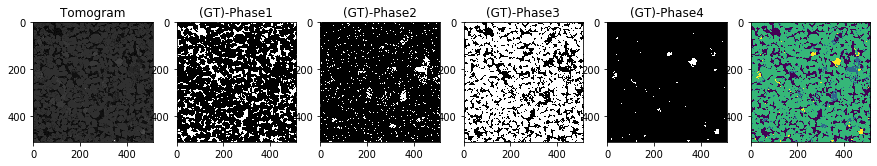

In [81]:
plot_sample_GT(X_valid, y_valid, r=0)

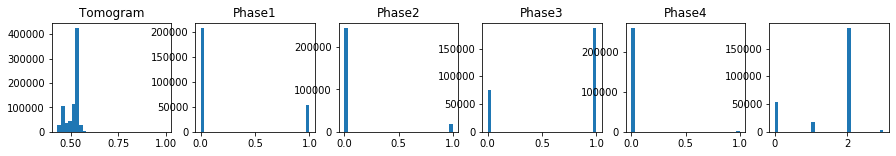

In [82]:
plot_sample_hist(X_valid, y_valid, r=0)

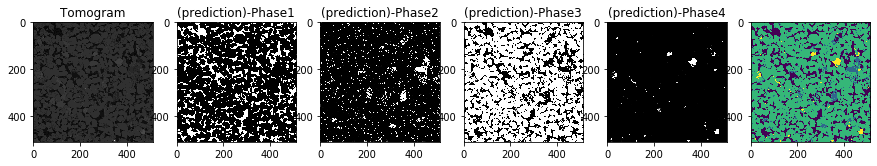

In [83]:
plot_sample_predict(X_valid, preds_val, r=0)

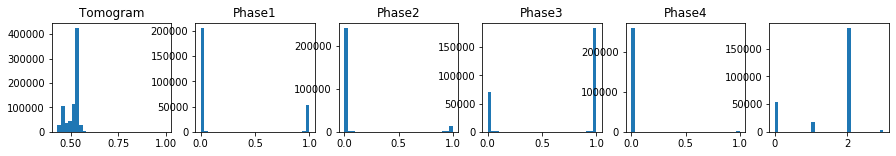

In [84]:
plot_sample_hist(X_valid, preds_val, r=0)

In [65]:
from keras import backend as K

def iou_loss(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)
    iou1 = np.mean((intersection[:,:,:,1] + K.epsilon())/(union[:,:,:,1] + K.epsilon()))
    iou0 = np.mean((intersection[:,:,:,0] + K.epsilon())/(union[:,:,:,0] + K.epsilon()))
    iou2 = np.mean((intersection[:,:,:,2] + K.epsilon())/(union[:,:,:,2] + K.epsilon()))
    iou3 = np.mean((intersection[:,:,:,3] + K.epsilon())/(union[:,:,:,3] + K.epsilon()))
    return iou3,iou1,iou0,iou2,np.mean((K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon()))



In [66]:
iou = iou_loss(y_test[0:10], preds_test[0:10])
print(iou)

(0.99169016, 0.82932156, 0.8580278, 0.8383771, 0.80790246)


In [76]:
import skimage
import pandas as pd
from skimage.measure import label, regionprops, regionprops_table
phase =preds_val[2,...,2]
print(phase.shape)
phase= label(phase)
regions=skimage.measure.regionprops(phase)
eulernumber=regionprops_table(phase, properties=['euler_number'])
l=pd.DataFrame(eulernumber)
print(np.min(l),np.max(l))

(512, 512)
euler_number   -1633
dtype: int64 euler_number    1
dtype: int64
